# Experiment 2: LocalMax Acquisition Functions
This notebook shows detailed plots of the experiments on changing the underlying sequential acquisition function within local max. The experiment tests the impact of varrying acquisition functions on each dataset. 

Acquisition functions:
- uncertainty
- vopt
- model change
- mcvopt

Embeddings:
- CNNVAE
- Zero-shot Transfer Learning
- Fine Tuned Transfer Learning

Datasets:
- MSTAR
- OpenSARShip
- FUSAR-Ship

In [1]:
#Check the GPU and RAM
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Wed Jan 25 21:13:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    55W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#Mount drive and install python packages
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('drive/MyDrive/SAR_BAL')

Mounted at /content/drive


In [3]:
!pip install graphlearning annoy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 KB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 648.0/648.0 KB 16.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for graphlearning: filename=graphlearning-1.2.1-cp38-cp38-linux_x86_64.whl size=158928 sha256=1d34a507ab566f69f6e8dd7ac8fe8b9d12f6a8ba24d7369bb9c04b94a564c620
  Stored in directory: /root/.cache/pip/wheels/5e/84/62/681cf2c2a59f1f5e58d52fb110e2eb4c93c9c808d932829543
  Created wheel for annoy: filename=annoy-1.17.1-cp38-cp38-linux_x86_64.whl size=581455 sha256=d123f42bc94830c2e6cf1069f24f770fcf9b11daf3a79802e21a1752143de057
  Stored in directory: /root/.cache/pip/wheels/f9/93/19/30511c4a9ae6b4937455a134c34a39e13943e2c6f46fcd2ed2
  error: subprocess-exited-with-error
  
  × python setup.py bdist_w

In [4]:
from utils import AVAILABLE_SAR_DATASETS, AVAILABLE_EMBEDDINGS
from experiments import experiment_2

from models import CVAE

## Parameters

In [5]:
#Non-default Parameters

HARDWARE_ACCELERATION = True

## Running Experiments

mstar cnnvae
Using pre-computed cnnvae embedding knn_data


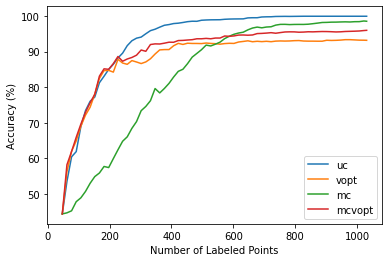

mstar zero_shot_tl


Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

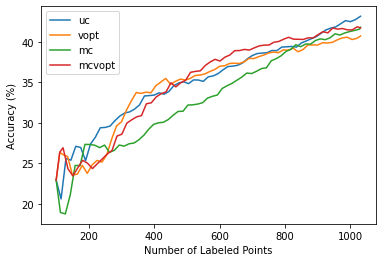

mstar fine_tuned_tl


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training model for 30 epochs
Training complete in 9m 8s
Best val Acc: 0.249923


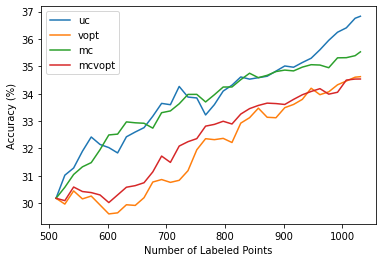

open_sar_ship cnnvae
Using pre-computed cnnvae embedding knn_data


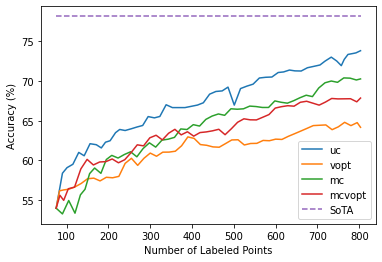

open_sar_ship zero_shot_tl


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

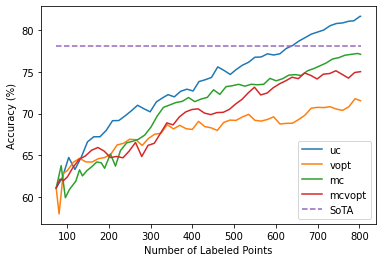

open_sar_ship fine_tuned_tl


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training model for 30 epochs
Training complete in 2m 56s
Best val Acc: 0.501146


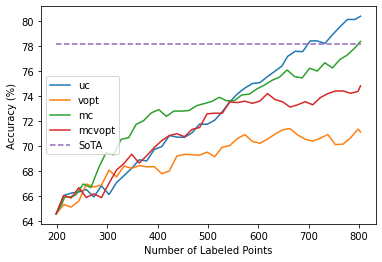

fusar cnnvae
Using pre-computed cnnvae embedding knn_data


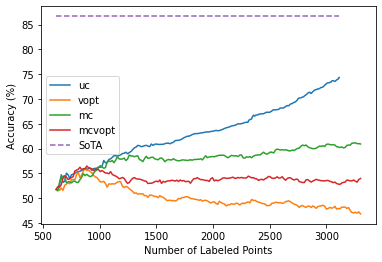

fusar zero_shot_tl


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X0_5_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X0_5_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/shufflenetv2_x0.5-f707e7126e.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x0.5-f707e7126e.pth


  0%|          | 0.00/5.28M [00:00<?, ?B/s]

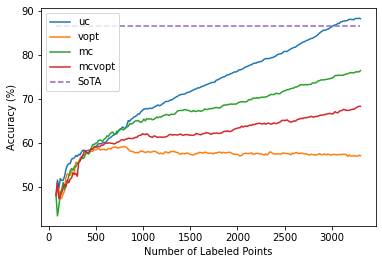

fusar fine_tuned_tl


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X0_5_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X0_5_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training model for 30 epochs
Training complete in 6m 34s
Best val Acc: 0.435942


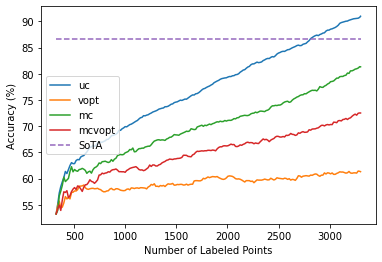

In [6]:
for dataset in AVAILABLE_SAR_DATASETS:
    for embedding in AVAILABLE_EMBEDDINGS:
        print(dataset + " " + embedding)
        experiment_2(dataset, embedding, hardware_acceleration=HARDWARE_ACCELERATION)